# ДЗ рекомендательные системы №2

# Файзуллов Айрат

## 1) Реализовать метрики ранжирования MAP, MRR, NDCG

In [ ]:
import numpy as np

In [ ]:
# MAP realisation
def own_map(matr_in, n_elements, threshold):
  if n_elements > len(matr_in[0, :]):
    n_elements = len(matr_in[0, :])
  avg_prec = 0
  matr_to_count = matr_in > threshold
  for i in range(n_elements):
    avg_prec += np.sum(matr_to_count[:, :i+1], axis=1)/(i+1) * (matr_to_count)[:, i]
  avg_prec = avg_prec / n_elements
  res = np.sum(avg_prec) / len(matr_in[:])
  return res


#MRR realisation
def own_mrr(matr_in, threshold):
  return np.sum(1 / (np.argmax(matr_in > threshold, axis=1) + 1)) / len(matr_in[:])


#NDCG realisation
def own_ndcg(matr_in, n_elements, threshold):
  matr_to_count = matr_in > threshold
  matr_to_count = matr_to_count[:, :n_elements]
  ind = np.arange(2, len(matr_to_count[0]) + 2)
  ind = np.log2(ind)
  return np.sum(np.sum(matr_to_count/ind, axis=1) / np.sum(1/ind)) / len(matr_to_count[:])

##Читаю данные

Читаю и предобратываю данные для обучения

In [ ]:
import pandas as pd

In [ ]:
train_table = pd.read_table('train.txt', sep=' ', header=None)

a = np.arange(2, 10)
a = list(a)
column_names = train_table.columns[a]

for column_name in column_names:
    train_table[column_name] = train_table[column_name].astype(str).str[2:]
    train_table[column_name] = train_table[column_name].astype(float)

a = np.arange(10, 48)
a = list(a)
column_names = train_table.columns[a]

for column_name in column_names:
    train_table[column_name] = train_table[column_name].astype(str).str[3:]
    train_table[column_name] = train_table[column_name].astype(float)

train_table[1] = train_table[1].astype(str).str[4:]
train_table[1] = train_table[1].astype(int)
train_table[0] = train_table[0].astype(int)


In [ ]:
test_table = pd.read_table('test.txt', sep=' ', header=None)

a = np.arange(2, 10)
a = list(a)
column_names = test_table.columns[a]

for column_name in column_names:
    test_table[column_name] = test_table[column_name].astype(str).str[2:]
    test_table[column_name] = test_table[column_name].astype(float)

a = np.arange(10, 48)
a = list(a)
column_names = test_table.columns[a]

for column_name in column_names:
    test_table[column_name] = test_table[column_name].astype(str).str[3:]
    test_table[column_name] = test_table[column_name].astype(float)

test_table[1] = test_table[1].astype(str).str[4:]
test_table[1] = test_table[1].astype(int)
test_table[0] = test_table[0].astype(int)

In [ ]:
lst_col = np.arange(1, 48)

## 2) Нужно реализовать алгоритм ранжирования LambdaRank или LambdaMART

Я буду реализовывать LambdaRank

Подготовил простейшую полносвязную сеть

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 46
hidden_size = 64
output_size = 1

model = SimpleNN(input_size, hidden_size, output_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

Обучение модели на метрике NDCG и её тестирвоание. Считаю качетсво на лучших 50 объектах

In [ ]:
mean_acc = []
mean_acc_test = []

lst_col = np.arange(2, 48)

for epoch in range(10):
  acc_val_epoch = []

  #model.train()
  for queu in train_table[1].unique():

    q_10 = train_table[train_table[1] == queu]
    docs = torch.from_numpy(np.array(q_10[list(lst_col)], dtype="float32"))
    docs = docs.to(device)
    doc_scores = model(docs)

    (sorted_scores, sorted_idxs) = doc_scores.sort(dim=0, descending=True)

    n_docs = len(q_10[0])
    n_rel = len(q_10[0][q_10[0] > 0]) # считаю кол-во релевантых объектов и расставляю doc_scores в порядке релевантности
    n_irr = n_docs - n_rel



    # print(q_10[0].iloc[list(sorted_idxs)])
    score_diffs = sorted_scores[:n_rel] - sorted_scores[n_rel:].view(n_irr)  # create all pairs with rel and irr
    exped = score_diffs.exp()    # exp substract
    # exped

    acc_value = own_ndcg(np.array(q_10[0].iloc[list(sorted_idxs)])[np.newaxis, :], 50, 0)

    lst_sorted = list(sorted_idxs)

    # count lambda for SGD
    matrix_for_lambda = []
    for i in range(n_rel):
      a = int(lst_sorted[i])
      line_arr = []
      for j in range(n_rel, n_docs):
        tmp_indx = np.array(sorted_idxs).reshape(-1)
        b = int(lst_sorted[j])
        tmp_indx[[i, j]] = [b, a]
        diff_acc = abs((acc_value - own_ndcg(np.array(q_10[0].iloc[list(tmp_indx)])[np.newaxis, :], 50, 0)))
        line_arr.append(diff_acc)
      matrix_for_lambda.append(np.array(line_arr))


    if matrix_for_lambda != []:
      matrix_for_lambda = 1 / (1 + exped) * torch.tensor(matrix_for_lambda)
    else:
      continue

    lambs = torch.zeros((n_docs, 1)).to(device)
    lambs[:n_rel] += matrix_for_lambda.sum(dim=1, keepdim=True)
    lambs[n_rel:] -= matrix_for_lambda.sum(dim=0, keepdim=True).t()

    model.zero_grad()
    sorted_scores.backward(lambs)

    # Change params
    lr = 0.00001
    with torch.no_grad():
        for param in model.parameters():
            param += lr * param.grad

    acc_val_epoch.append(acc_value)

  print("-----EPOCH_PASSED------")
  print(np.array(acc_val_epoch).mean())
  mean_acc.append(np.array(acc_val_epoch).mean())


  # count accuracy on test dataset
  acc_val_epoch_test = []
  model.eval()
  with torch.no_grad():
    for queu_test in test_table[1].unique():
      q_10 = test_table[test_table[1] == queu_test]
      docs = torch.from_numpy(np.array(q_10[list(lst_col)], dtype="float32"))
      docs = docs.to(device)
      doc_scores = model(docs)

      (sorted_scores, sorted_idxs) = doc_scores.sort(dim=0, descending=True)
      acc_value = own_ndcg(np.array(q_10[0].iloc[list(sorted_idxs)])[np.newaxis, :], 50, 0)
      acc_val_epoch_test.append(acc_value)

    mean_acc_test.append(np.array(acc_val_epoch_test).mean())



Отобразим результат на графике

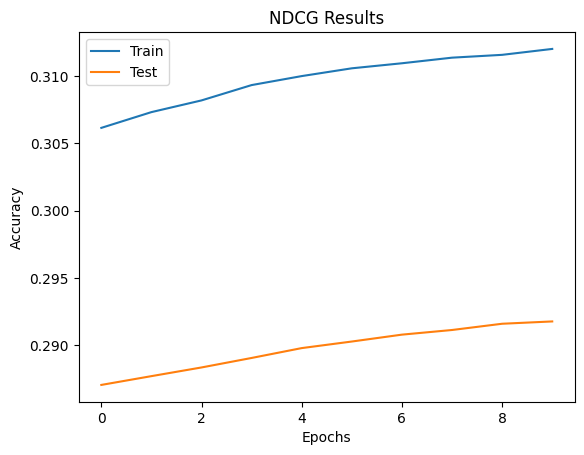

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Пример данных
x = np.arange(10)
y1 = mean_acc
y2 = mean_acc_test

# Создаем DataFrame
data = {'Epochs': x, 'Accuracy': y1, 'Y2': y2}
df = pd.DataFrame(data)

sns.lineplot(x='Epochs', y='Accuracy', data=df, label='Train')
sns.lineplot(x='Epochs', y='Y2', data=df, label='Test')

plt.title('NDCG Results')
plt.legend()

plt.show()

Видно, что результат улучшается, с кол-вом эпох. Только рост довольно медленный, вероятно всего это происходит из за того, что мы считаем качество по большому числу объектов

Обучение модели на метрике MRR и её тестирвоание

In [ ]:
mean_acc = []
mean_acc_test = []

lst_col = np.arange(2, 48)

for epoch in range(10):
  acc_val_epoch = []

  #model.train()
  for queu in train_table[1].unique():

    q_10 = train_table[train_table[1] == queu]
    docs = torch.from_numpy(np.array(q_10[list(lst_col)], dtype="float32"))
    docs = docs.to(device)
    doc_scores = model(docs)

    (sorted_scores, sorted_idxs) = doc_scores.sort(dim=0, descending=True)

    n_docs = len(q_10[0])
    n_rel = len(q_10[0][q_10[0] > 0]) # считаю кол-во релевантых объектов и расставляю doc_scores в порядке релевантности
    n_irr = n_docs - n_rel



    # print(q_10[0].iloc[list(sorted_idxs)])
    score_diffs = sorted_scores[:n_rel] - sorted_scores[n_rel:].view(n_irr)  # create all pairs with rel and irr
    exped = score_diffs.exp()    # exp substract
    # exped

    acc_value = own_mrr(np.array(q_10[0].iloc[list(sorted_idxs)])[np.newaxis, :], 0)

    lst_sorted = list(sorted_idxs)

    # count lambda for SGD
    matrix_for_lambda = []
    for i in range(n_rel):
      a = int(lst_sorted[i])
      line_arr = []
      for j in range(n_rel, n_docs):
        tmp_indx = np.array(sorted_idxs).reshape(-1)
        b = int(lst_sorted[j])
        tmp_indx[[i, j]] = [b, a]
        diff_acc = abs((acc_value - own_mrr(np.array(q_10[0].iloc[list(tmp_indx)])[np.newaxis, :], 0)))
        line_arr.append(diff_acc)
      matrix_for_lambda.append(np.array(line_arr))


    if matrix_for_lambda != []:
      matrix_for_lambda = 1 / (1 + exped) * torch.tensor(matrix_for_lambda)
    else:
      continue

    lambs = torch.zeros((n_docs, 1)).to(device)
    lambs[:n_rel] += matrix_for_lambda.sum(dim=1, keepdim=True)
    lambs[n_rel:] -= matrix_for_lambda.sum(dim=0, keepdim=True).t()

    model.zero_grad()
    sorted_scores.backward(lambs)

    # Change params
    lr = 0.00001
    with torch.no_grad():
        for param in model.parameters():
            param += lr * param.grad

    acc_val_epoch.append(acc_value)

  print("-----EPOCH_PASSED------")
  print(np.array(acc_val_epoch).mean())
  mean_acc.append(np.array(acc_val_epoch).mean())


  # count accuracy on test dataset
  acc_val_epoch_test = []
  model.eval()
  with torch.no_grad():
    for queu_test in test_table[1].unique():
      q_10 = test_table[test_table[1] == queu_test]
      docs = torch.from_numpy(np.array(q_10[list(lst_col)], dtype="float32"))
      docs = docs.to(device)
      doc_scores = model(docs)

      (sorted_scores, sorted_idxs) = doc_scores.sort(dim=0, descending=True)
      acc_value = own_mrr(np.array(q_10[0].iloc[list(sorted_idxs)])[np.newaxis, :], 0)
      acc_val_epoch_test.append(acc_value)

    mean_acc_test.append(np.array(acc_val_epoch_test).mean())


Отобразим результат на графике

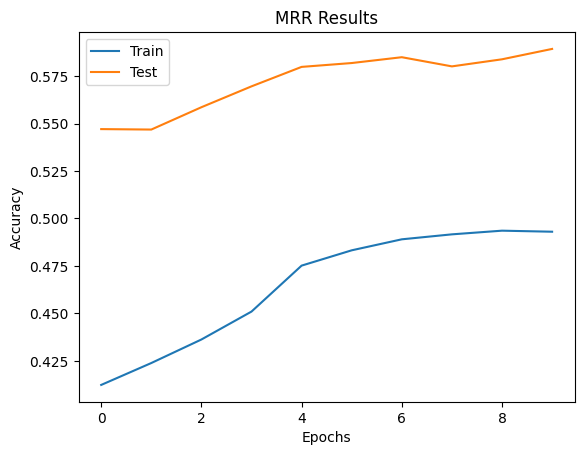

In [ ]:
x = np.arange(10)
y1 = mean_acc
y2 = mean_acc_test

# Создаем DataFrame
data = {'Epochs': x, 'Accuracy': y1, 'Y2': y2}
df = pd.DataFrame(data)

sns.lineplot(x='Epochs', y='Accuracy', data=df, label='Train')
sns.lineplot(x='Epochs', y='Y2', data=df, label='Test')

plt.title('MRR Results')
plt.legend()

plt.show()

Видим, что качество на MRR кажется лучше, чем при метрике NDCG. И рост качество выглядит более скачкообразно

Обучение модели на метрике MAP и её тестирвоание

In [ ]:
mean_acc = []
mean_acc_test = []

lst_col = np.arange(2, 48)

for epoch in range(10):
  acc_val_epoch = []

  #model.train()
  for queu in train_table[1].unique():

    q_10 = train_table[train_table[1] == queu]
    docs = torch.from_numpy(np.array(q_10[list(lst_col)], dtype="float32"))
    docs = docs.to(device)
    doc_scores = model(docs)

    (sorted_scores, sorted_idxs) = doc_scores.sort(dim=0, descending=True)

    n_docs = len(q_10[0])
    n_rel = len(q_10[0][q_10[0] > 0]) # считаю кол-во релевантых объектов и расставляю doc_scores в порядке релевантности
    n_irr = n_docs - n_rel



    # print(q_10[0].iloc[list(sorted_idxs)])
    score_diffs = sorted_scores[:n_rel] - sorted_scores[n_rel:].view(n_irr)  # create all pairs with rel and irr
    exped = score_diffs.exp()    # exp substract
    # exped

    acc_value = own_map(np.array(q_10[0].iloc[list(sorted_idxs)])[np.newaxis, :], 4, 0)

    lst_sorted = list(sorted_idxs)

    # count lambda for SGD
    matrix_for_lambda = []
    for i in range(n_rel):
      a = int(lst_sorted[i])
      line_arr = []
      for j in range(n_rel, n_docs):
        tmp_indx = np.array(sorted_idxs).reshape(-1)
        b = int(lst_sorted[j])
        tmp_indx[[i, j]] = [b, a]
        diff_acc = abs((acc_value - own_map(np.array(q_10[0].iloc[list(tmp_indx)])[np.newaxis, :], 4, 0)))
        line_arr.append(diff_acc)
      matrix_for_lambda.append(np.array(line_arr))


    if matrix_for_lambda != []:
      matrix_for_lambda = 1 / (1 + exped) * torch.tensor(matrix_for_lambda)
    else:
      continue

    lambs = torch.zeros((n_docs, 1)).to(device)
    lambs[:n_rel] += matrix_for_lambda.sum(dim=1, keepdim=True)
    lambs[n_rel:] -= matrix_for_lambda.sum(dim=0, keepdim=True).t()

    model.zero_grad()
    sorted_scores.backward(lambs)

    # Change params
    lr = 0.00001
    with torch.no_grad():
        for param in model.parameters():
            param += lr * param.grad

    acc_val_epoch.append(acc_value)

  print("-----EPOCH_PASSED------")
  print(np.array(acc_val_epoch).mean())
  mean_acc.append(np.array(acc_val_epoch).mean())


  # count accuracy on test dataset
  acc_val_epoch_test = []
  model.eval()
  with torch.no_grad():
    for queu_test in test_table[1].unique():
      q_10 = test_table[test_table[1] == queu_test]
      docs = torch.from_numpy(np.array(q_10[list(lst_col)], dtype="float32"))
      docs = docs.to(device)
      doc_scores = model(docs)

      (sorted_scores, sorted_idxs) = doc_scores.sort(dim=0, descending=True)
      acc_value = own_map(np.array(q_10[0].iloc[list(sorted_idxs)])[np.newaxis, :], 4, 0)
      acc_val_epoch_test.append(acc_value)

    mean_acc_test.append(np.array(acc_val_epoch_test).mean())



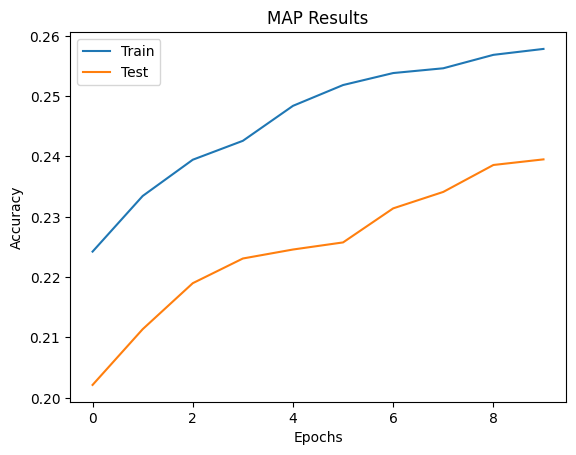

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Пример данных
x = np.arange(10)
y1 = mean_acc
y2 = mean_acc_test

# Создаем DataFrame
data = {'Epochs': x, 'Accuracy': y1, 'Y2': y2}
df = pd.DataFrame(data)

sns.lineplot(x='Epochs', y='Accuracy', data=df, label='Train')
sns.lineplot(x='Epochs', y='Y2', data=df, label='Test')

plt.title('MAP Results')
plt.legend()

plt.show()

Видим, что качество растет. И рост происходит заметнее по сравнению с метрикой NDCG, т.к. в этом эксперименте мы считали качество по 4 лучшим объектам.

## Применить алгоритм к дастасэту movielens

In [ ]:
! unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [157]:
train_my_X = pd.read_table('ml-100k/ua.base')
train_my_X = train_my_X.rename(columns={"1": "userId", "1.1": "movieId", "5": "rating"})
train_my_X = train_my_X.drop(["874965758"], axis=1)
test_my_X = pd.read_table('ml-100k/ua.test')
test_my_X = test_my_X.rename(columns={"1": "userId", "20": "movieId", "4": "rating"})
test_my_X = test_my_X.drop(["887431883"], axis = 1)

Берем информацию о пользователях и преобразуем их професси c OneHotEncoding

In [158]:
info_user = pd.read_table('ml-100k/u.user', sep='|', header=None)
info_user = info_user.drop([4], axis=1)
info_user[2] = info_user[2].map({'M': 0, 'F': 1})  # Convert Genders to binary
info_user = pd.get_dummies(info_user, columns=[3]) # OHE fro job
info_user = info_user.rename(columns={1: 'Age', 2: 'Gender', 0:'userId'})

Берём информации о жанре фильма

In [159]:
info_movie = pd.read_table('ml-100k/u.item', sep='|', header=None, encoding='latin-1')
info_movie = info_movie.drop([1, 2, 3, 4], axis=1) # information about movie genre
info_movie = info_movie.rename(columns={0: 'movieId'})

Сджойним всю имеющуюся информацию в изначальную таблицу

In [160]:
test_my_X = pd.merge(test_my_X, info_movie, on='movieId', how='inner')
test_my_X = pd.merge(test_my_X, info_user, on='userId', how='inner')
train_my_X = pd.merge(train_my_X, info_movie, on='movieId', how='inner')
train_my_X = pd.merge(train_my_X, info_user, on='userId', how='inner')

Обучение модели

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 42
hidden_size = 64
output_size = 1

model = SimpleNN(input_size, hidden_size, output_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [80]:
column_names = train_my_X.columns.tolist()
lst_col = column_names[3:]

In [ ]:
mean_acc = []
mean_acc_test = []

column_names = train_my_X.columns.tolist()
lst_col = column_names[3:]

for n_check in [10]:
  model = SimpleNN(input_size, hidden_size, output_size)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = model.to(device)

  for epoch in range(3):
    acc_val_epoch = []

    #model.train()
    for queu in train_my_X['userId'].unique():

      q_10 = train_my_X[train_my_X['userId'] == queu]
      docs = torch.from_numpy(np.array(q_10[list(lst_col)], dtype="float32"))
      docs = docs.to(device)
      doc_scores = model(docs)

      (sorted_scores, sorted_idxs) = doc_scores.sort(dim=0, descending=True)

      n_docs = len(q_10['rating'])
      n_rel = len(q_10['rating'][q_10['rating'] > 3]) # считаю кол-во релевантых объектов и расставляю doc_scores в порядке релевантности
      n_irr = n_docs - n_rel



      # print(q_10[0].iloc[list(sorted_idxs)])
      score_diffs = sorted_scores[:n_rel] - sorted_scores[n_rel:].view(n_irr)  # create all pairs with rel and irr
      exped = score_diffs.exp()    # exp substract
      # exped

      acc_value = own_ndcg(np.array(q_10['rating'].iloc[list(sorted_idxs)])[np.newaxis, :], n_check, 3)

      lst_sorted = list(sorted_idxs)

      # count lambda for SGD
      matrix_for_lambda = []
      for i in range(n_rel):
        a = int(lst_sorted[i])
        line_arr = []
        for j in range(n_rel, n_docs):
          tmp_indx = np.array(sorted_idxs).reshape(-1)
          b = int(lst_sorted[j])
          tmp_indx[[i, j]] = [b, a]
          diff_acc = abs((acc_value - own_ndcg(np.array(q_10['rating'].iloc[list(tmp_indx)])[np.newaxis, :], n_check, 3)))
          line_arr.append(diff_acc)
        matrix_for_lambda.append(np.array(line_arr))


      if matrix_for_lambda != []:
        matrix_for_lambda = 1 / (1 + exped) * torch.tensor(matrix_for_lambda)
      else:
        continue

      lambs = torch.zeros((n_docs, 1)).to(device)
      lambs[:n_rel] += matrix_for_lambda.sum(dim=1, keepdim=True)
      lambs[n_rel:] -= matrix_for_lambda.sum(dim=0, keepdim=True).t()

      model.zero_grad()
      sorted_scores.backward(lambs)

      # Change params
      lr = 0.00001
      with torch.no_grad():
          for param in model.parameters():
              param += lr * param.grad

      acc_val_epoch.append(acc_value)

    print("-----EPOCH_PASSED------")
    print(np.array(acc_val_epoch).mean())
    mean_acc.append(np.array(acc_val_epoch).mean())


    # count accuracy on test dataset
    acc_val_epoch_test = []
    model.eval()
    with torch.no_grad():
      for queu_test in test_my_X['userId'].unique():
        q_10 = test_my_X[test_my_X['userId'] == queu_test]
        docs = torch.from_numpy(np.array(q_10[list(lst_col)], dtype="float32"))
        docs = docs.to(device)
        doc_scores = model(docs)

        (sorted_scores, sorted_idxs) = doc_scores.sort(dim=0, descending=True)
        acc_value = own_ndcg(np.array(q_10['rating'].iloc[list(sorted_idxs)])[np.newaxis, :], n_check, 3)
        acc_val_epoch_test.append(acc_value)

      mean_acc_test.append(np.array(acc_val_epoch_test).mean())


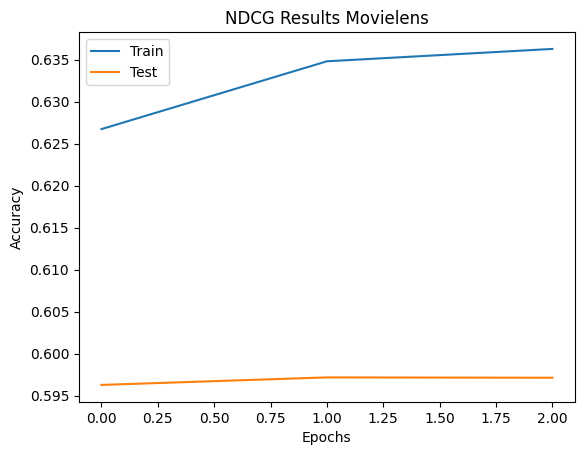

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Пример данных
x = np.arange(3)
y1 = mean_acc
y2 = mean_acc_test

# Создаем DataFrame
data = {'Epochs': x, 'Accuracy': y1, 'Y2': y2}
df = pd.DataFrame(data)

sns.lineplot(x='Epochs', y='Accuracy', data=df, label='Train')
sns.lineplot(x='Epochs', y='Y2', data=df, label='Test')

plt.title('NDCG Results Movielens')
plt.legend()

plt.show()

Обучили модели с метрикой NDCG по 10 лучшим рекомендациям. Видим, что модель обучается  и качество медленно растет. Обучал на 3 эпохах

Проведём эксперименты с SVD

In [108]:
train_my_X = pd.read_table('ml-100k/ua.base')
train_my_X = train_my_X.rename(columns={"1": "userId", "1.1": "movieId", "5": "rating"})
train_my_X = train_my_X.drop(["874965758"], axis=1)
test_my_X = pd.read_table('ml-100k/ua.test')
test_my_X = test_my_X.rename(columns={"1": "userId", "20": "movieId", "4": "rating"})
test_my_X = test_my_X.drop(["887431883"], axis = 1)

train_my_Y = train_my_X['rating']
test_my_Y = test_my_X['rating']
test_my_X = test_my_X.drop(['rating'], axis=1)

In [113]:
P = np.random.normal(0, 1, (len(train_my_X['userId'].drop_duplicates()), n_factors))
Q = np.random.normal(0, 1, (n_factors, len(train_my_X['movieId'].drop_duplicates())))

b_i = np.zeros(len(train_my_X['movieId'].drop_duplicates()))
b_u = np.zeros(len(train_my_X['userId'].drop_duplicates()))

result = ((np.dot(P, Q) + b_i).T + b_u).T

sorted_movie = np.sort(train_my_X['movieId'].drop_duplicates())
lst_ind = np.arange(0, 1680)

def fit_SGD(lr, lambda_v, result, P, Q, b_u, b_i, iter_n):
  for t in range(0, iter_n):
    i = np.random.randint(90568)
    p_u = train_my_X.iloc[i]['userId'] - 1
    # q_i = train_my_X.iloc[i]['movieId'] - 2
    q_i = np.where(sorted_movie == train_my_X.iloc[i]['movieId'])[0][0]
    # q_i = np.where(np.array(train_my_X['movieId']) == train_my_X.iloc[i]['movieId'] )[0][0]
    e_ij = train_my_Y[i] - result[p_u, q_i]
    b_u = b_u + lr*(e_ij - lambda_v*b_u)
    b_i = b_i + lr*(e_ij - lambda_v*b_i)
    P[p_u] = P[p_u] + lr*(e_ij*Q[:, q_i] - lambda_v * P[p_u])
    Q[:, q_i] = Q[:, q_i] + lr*(e_ij * P[p_u] - lambda_v * Q[:, q_i])
    result = ((np.dot(P, Q) + b_i).T + b_u).T
  return result

def pred_r():
  ans = np.array([])
  for t in range (0, len(test_my_Y)):
    i = test_my_X.iloc[t]['userId'] - 1
    j = np.where(sorted_movie == train_my_X.iloc[t]['movieId'])[0][0]
    # j = test_my_X.iloc[t]['movieId'] - 2
    # print(np.dot(P[i], Q[:, j]) + b_u[i] + b_i[j])
    ans = np.append(ans, result[i][j])
  return ans

In [116]:
import time
from sklearn.metrics import mean_squared_error

In [119]:
x1 = [5000, 10000, 15000, 20000, 25000]
a_mean = []
b_basic = []
time_SGD_n = []
rmse_SGD_n = []
for i in ([25000]):
  n_factors = 4

  P = np.random.normal(0, 1, (len(train_my_X['userId'].drop_duplicates()), n_factors))
  Q = np.random.normal(0, 1, (n_factors, len(train_my_X['movieId'].drop_duplicates())))

  b_i = np.zeros(len(train_my_X['movieId'].drop_duplicates()))
  b_u = np.zeros(len(train_my_X['userId'].drop_duplicates()))

  result = ((np.dot(P, Q) + b_i).T + b_u).T
  start_time = time.time()
  result = fit_SGD(0.005, 0.02, result, P, Q, b_u, b_i, i)
  r_pred = pred_r()
  print("--- %s seconds ---" % (time.time() - start_time))
  time_SGD_n.append([time.time() - start_time])
  rmse_SGD_n.append(mean_squared_error(test_my_Y, r_pred, squared=False))

--- 339.33766889572144 seconds ---


In [123]:
test_my_X['true_rating'] = test_my_Y
test_my_X['pred_rating'] = r_pred

Качество при SVD

In [156]:
acc_val_epoch_test = []

for i in([3, 5, 10]):
  for queu_test in test_my_X['userId'].unique():
    q_10 = test_my_X[test_my_X['userId'] == queu_test]
    doc_scores = q_10['pred_rating']

    sorted_series = doc_scores.sort_values(ascending=False)
    sorted_idxs = sorted_series.index - min(sorted_series.index)
    acc_value = own_ndcg(np.array(q_10['true_rating'].iloc[list(sorted_idxs)])[np.newaxis, :], i, 3)
    acc_val_epoch_test.append(acc_value)

  print("NDCG_SVD with", i, "elements")
  print(np.array(acc_val_epoch_test).mean())

NDCG_SVD with 3 elements
0.5812841306017431
NDCG_SVD with 5 elements
0.5822581741968068
NDCG_SVD with 10 elements
0.5817323697615465


Качество при LambdaRank

In [ ]:
mean_acc_test_1 = []
for i in([3, 5, 10]):
  acc_val_epoch_test = []
  model.eval()
  with torch.no_grad():
    for queu_test in test_my_X['userId'].unique():
      q_10 = test_my_X[test_my_X['userId'] == queu_test]
      docs = torch.from_numpy(np.array(q_10[list(lst_col)], dtype="float32"))
      docs = docs.to(device)
      doc_scores = model(docs)

      (sorted_scores, sorted_idxs) = doc_scores.sort(dim=0, descending=True)
      acc_value = own_ndcg(np.array(q_10['rating'].iloc[list(sorted_idxs)])[np.newaxis, :], i, 3)
      acc_val_epoch_test.append(acc_value)
    mean_acc_test_1.append(np.array(acc_val_epoch_test).mean())

In [164]:
a = [3, 5, 10]
j = -1
for i in mean_acc_test_1:
  j += 1
  print("NDCG_LAMBDARANK with", a[j], "elements")
  print(i)

NDCG_LAMBDARANK with 3 elements
0.6379792422900793
NDCG_LAMBDARANK with 5 elements
0.6278356903595199
NDCG_LAMBDARANK with 10 elements
0.5971201539274222


Качество NDCG при SVD = 0.58. Можно сделать вывод, что SVD не силньно уступает по качеству нейронной сети с LambdaRank.

## Вывод

Нейронная сеть с LambdaRank довольно долго обучается и имеет качество  лучше чем при обычном SVD и выдает более точные результаты для первых значений. LambdRank даёт лучшее качество при малом кол-ве выдаваемых рекомендаций, в отличии от SVD( качество которого заметно не меняется при 10, 5, 3 элементах).